In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# veri setini okuyalım:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [3]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Doğal afet ile ilgili tweet lerden oluşan veri seti üzerinde çalışağız.

1 -> gerçek bir felaket tweeti

0 -> gerçek olmayan bir felaket tweeti


problemimiz için binary classification model kullanacağız.

In [4]:
# train datasını karıştıralım:
train_df_shuffled = train_df.sample(frac=1, random_state=42) # tekrarlanabilirlik için random_state=42
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-imaginable destruction.,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0


In [5]:
# Sınıfların dağılımına bakalım:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


yaklaşık %60 negatif sınıf (target = 0) ve

%40 pozitif sınıf (target = 1)

In [6]:
# satır sayısına bakalım:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


# Model Kurma Hazırlık Aşaması

In [7]:
from sklearn.model_selection import train_test_split

# train & validasyon datası
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # validation set
                                                                            random_state=42)

In [8]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [9]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

# Temel Model: Model_1

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# tokenization ve model pipeline i oluşturalım:
model_1 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # vektörleştirme için TF-IDF
                    ("clf", MultinomialNB()) # classifier modeli
])

# train datasında fit edelim:
model_1.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [11]:
# temel modeli değerlendirelim:

baseline_score = model_1.score(val_sentences, val_labels)
print(f"temel modelin başarısı: {baseline_score*100:.2f}%")

temel modelin başarısı: 79.27%


In [12]:
# validasyon setinde tahminleme yapalım:

baseline_preds = model_1.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [13]:
# değerlendirme fonksiyonu oluşturalım:accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [14]:
# Başarı metriklerini görelim:

model_1_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
model_1_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

**örnek tweet üzerinde deneme**

In [15]:
new_tweet = ["Earthquake hits central California, buildings damaged."]
prediction = model_1.predict(new_tweet)

print("Prediction:", prediction[0])

Prediction: 1


In [16]:
fake_tweet = ["Free burgers for everyone due to the storm!"]
prediction = model_1.predict(fake_tweet)

print("Prediction:", prediction[0])

Prediction: 0


# Derin Öğrenme Modeli: Model_2

Basit Derin Öğrenme Metin Sınıflandırıcı (DNN) kullancağız.

text vectorization + embedding + average pooling + dense sigmoid

In [17]:
# TextVectorization kullanarak metin vektörleştirme yapalım

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

max_vocab_length = 10000 # kelime dağarcığımızda bulunması gereken maksimum kelime sayısı
max_length = 15 # dizideki max uzunluk  (bu örnek için kaç kelimelik tweet olmalı?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # kelime dağarcığındaki maksimum benzersiz kelime sayısıdır
                                    standardize="lower_and_strip_punctuation", # Metni küçük harfe çevirir ve noktalama işaretlerini temizler
                                    split="whitespace", # Metni boşluklara göre ayırır
                                    ngrams=None, # N-gram lara ayırır, none -> tek tek kelimeler alınır yani unigram
                                    output_mode="int", # Kelimeleri tamsayıya dönüştürür (token ID)
                                    output_sequence_length=None) # Her bir çıktı dizisinin uzunluğunu sabitler.None -> her cümle uzunluğunda kalır.

sinir ağlarında kullanabilmek içn bir katman oluşturalım.

In [18]:
# Embedding katmanı kullanark Embedding oluşturalım:

# # kodu her çalıştırdığında aynı sonuçları almak için:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # kelime dağarcığındaki toplam benzersiz kelime sayısı
                             output_dim=128, # Her kelimenin temsil edileceği vektörün boyutu (embedding size)
                             embeddings_initializer="uniform", # Ağırlıkların başlatılma yöntemi (default: rastgele)
                             input_length=max_length, # Her giriş dizisinin uzunluğu
                             name="embedding_1")      # Katmana özel bir isim

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# text vectorizer i train datasına uygulayalım:
text_vectorizer.adapt(train_sentences)

In [20]:
# TensorFlow ve Keras kullanarak bir metin sınıflandırma modeli oluşturalım:
# Modelin amacı, bir metin girdisini alıp, 0 veya 1 gibi ikili (binary) bir sınıf tahmini yapmaktır

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # girdi katmanı, her örnek tek satırlık metin olacak, veri tipi string

x = text_vectorizer(inputs) # yukarda tanımladığımız TextVectorization katmanı
# Ham metin verisi, sayısal değerlere (token dizilerine) dönüştürülür

x = embedding(x) # yukarda tanımladığımız embedding katmanı
# Sayıya çevrilmiş kelimeler, embedding (gömülü) vektörlerine dönüştürülüyor

x = layers.GlobalAveragePooling1D()(x) # Bu katman, vektörlerin ortalamasını alarak tek bir sabit vektör elde eder.

outputs = layers.Dense(1, activation="sigmoid")(x) # çıkış katmanı: 1 adet nöron, aktivasyon fonksiyonu sigmoid(0 ile 1 arasında olasılık verir)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_dense") # Girdi ve çıktı katmanlarıyla bir model nesnesi oluşturulur

In [21]:
# Get a summary of the model
model_2.summary()

Model: "model_2_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Modeli eğitime hazırlamak için; Compile model
model_2.compile(loss="binary_crossentropy",   # kayıp fonksiyonu
                optimizer=tf.keras.optimizers.Adam(), # Optimizasyon algoritması
                metrics=["accuracy"])   #değerlendirme metriği

In [23]:
# Artık .fit() ile modeli eğitebiliriz:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5954 - loss: 0.6637 - val_accuracy: 0.7690 - val_loss: 0.5772
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7933 - loss: 0.5130 - val_accuracy: 0.7900 - val_loss: 0.4949
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8404 - loss: 0.4028 - val_accuracy: 0.7992 - val_loss: 0.4674
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8720 - loss: 0.3351 - val_accuracy: 0.8058 - val_loss: 0.4609
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8903 - loss: 0.2851 - val_accuracy: 0.8031 - val_loss: 0.4660


In [24]:
# modelin, doğrulama verisi üzerindeki başarısını ölçelim:

loss, accuracy = model_2.evaluate(val_sentences, val_labels)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7809 - loss: 0.5017
Validation Loss: 0.4660
Validation Accuracy: 0.8031


In [25]:
# Embedding katmanının öğrenilmiş ağırlıklarını (vektörlerini) görelim:
embedding.weights

[<Variable path=embedding_1/embeddings, shape=(10000, 128), dtype=float32, value=[[ 0.0141412   0.0254839   0.02919754 ... -0.0426272   0.00084205
   -0.02219932]
  [-0.00583038  0.00818451 -0.02228809 ...  0.03239937 -0.03933227
   -0.01366801]
  [ 0.01828996 -0.00083011 -0.01724912 ...  0.01742412  0.00779379
   -0.05647046]
  ...
  [ 0.02023532 -0.09386612 -0.0330675  ... -0.09151986  0.04839116
   -0.06294928]
  [ 0.02815702 -0.09180109 -0.01932203 ... -0.03131067  0.049788
   -0.01045061]
  [ 0.02394488 -0.08858429 -0.05922697 ... -0.0680729   0.02501841
   -0.10448675]]>]

In [26]:
# her kelimenin vektörünün numpy dizisi olarak gösterilmesi:

embedding_matrix = embedding.weights[0].numpy()
print(embedding_matrix.shape)

(10000, 128)


In [27]:
# tahminde bulunalım
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[0.44725794],
       [0.7327753 ],
       [0.9945903 ],
       [0.2181207 ],
       [0.42308125],
       [0.9057214 ],
       [0.90679544],
       [0.98874795],
       [0.906286  ],
       [0.30377695],
       [0.19344078],
       [0.6405662 ],
       [0.12951116],
       [0.26412508],
       [0.01552677],
       [0.16154762],
       [0.09704622],
       [0.09325492],
       [0.3647967 ],
       [0.51176375]], dtype=float32)

In [28]:
# Tahmin olasılıklarını, tek boyutlu tensöre dönüştürelim:

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [29]:
# model_2 nin başarı metriğini hesaplayalım:

model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds.numpy())
model_2_results

{'accuracy': 0.8031496062992126,
 'precision': 0.8070248087120978,
 'recall': 0.8031496062992126,
 'f1': 0.800896883884174}

**örnek tweet üzerinde deneme**

In [30]:
# tweeti öncelikle "constant" ile TensorFlow'un anlayabileceği sabit tensöre çevireceğiz:

new_tweet = tf.constant(["Earthquake hits central California, buildings damaged."])
prediction = model_2.predict(new_tweet)

print("Prediction:", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: [1.]


In [31]:
fake_tweet = tf.constant(["Hurricane alert: buy 1 get 1 free on all sodas!"])
print(model_2.predict(fake_tweet))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[0.37113705]]


# LSTM (long short term memory) - Model_3

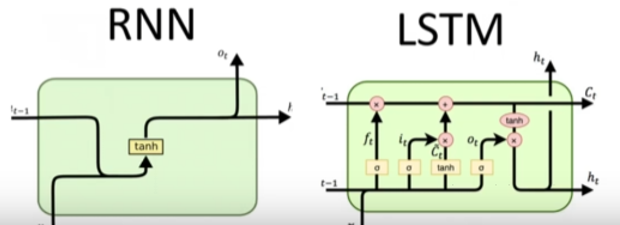

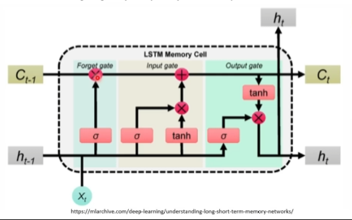

# not: yukarda text_vectorizer tanımdladığımız için tekrar burada tanımlamıyorum.

**text vectorization + embedding + LSTM + dense sigmoid**

In [32]:
# Text vectorizer
# text_vectorizer = TextVectorization(max_tokens=10000, # En sık geçen 10000 kelimelik kelime hazinesi oluşturur.
#                                     output_mode="int",
#                                     standardize="lower_and_strip_punctuation", # Küçük harfe çevirir ve noktalama işaretlerini temizler
#                                     split="whitespace", # Kelimeleri boşluklara göre ayırır
#                                     output_sequence_length=None) # Her bir çıktı dizisinin uzunluğunu sabitler.None -> her cümle uzunluğunda kalır.

# # Eğitim cümlelerinden kelime dağarcığını öğrenmesi için:
# text_vectorizer.adapt(train_sentences)

In [33]:
# embedding layer i oluşturalım:

# kodu her çalıştırdığında aynı sonuçları almak için:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length, # kelime sayısı
                                     output_dim=128,  # Her kelime 128 boyutlu bir vektörle temsil edilecek.
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string") # giriş olarak bir string (tweet)

# Token dizisine çevirelim:
x = text_vectorizer(inputs)

# Embedding'e geçirelim:
x = model_3_embedding(x)
print(x.shape)

# 64 boyutlu gizli durum vektörüyle bir LSTM katmanı oluşturalım:
x = layers.LSTM(64)(x)
print(x.shape)

# Çıkış, binary sınıf tahmini:
outputs = layers.Dense(1, activation="sigmoid")(x) # Çıkışı 0-1 arasında bir olasılık olarak verir (binary classification)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_LSTM")

(None, None, 128)
(None, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
model_3.summary()

Model: "model_3_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [36]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6668 - loss: 0.6086 - val_accuracy: 0.7533 - val_loss: 0.4833
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8493 - loss: 0.3692 - val_accuracy: 0.7743 - val_loss: 0.5489
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9203 - loss: 0.2122 - val_accuracy: 0.7690 - val_loss: 0.7310
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9512 - loss: 0.1336 - val_accuracy: 0.7572 - val_loss: 0.7730
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9678 - loss: 0.0931 - val_accuracy: 0.7585 - val_loss: 0.9196


In [37]:
# validasyon setinde ilk 20 tweet için tahminleri alalım:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


array([[0.0107625 ],
       [0.97179866],
       [0.99884766],
       [0.40379867],
       [0.9969878 ],
       [0.99873155],
       [0.3787395 ],
       [0.99883705],
       [0.99782467],
       [0.42015988],
       [0.00101155],
       [0.8551034 ],
       [0.0010089 ],
       [0.10210315],
       [0.00201931],
       [0.00197908],
       [0.0397468 ],
       [0.00957046],
       [0.46994615],
       [0.96534395]], dtype=float32)

In [38]:
#  0 veya 1'e yuvarla
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

model_3_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [39]:
# LSTM modelin başarısını hesaplayalım:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds.numpy())

model_3_results

{'accuracy': 0.7585301837270341,
 'precision': 0.7593999956661763,
 'recall': 0.7585301837270341,
 'f1': 0.756605147545421}

In [40]:
new_tweet = tf.constant(["Earthquake hits central California, buildings damaged."])
prediction = model_3.predict(new_tweet)

print("Prediction:", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction: [0.9994566]


In [41]:
fake_tweet = tf.constant(["Hurricane alert: buy 1 get 1 free on all sodas!"])
print(model_3.predict(fake_tweet))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.04517843]]


In [42]:
# modellerin başarı karşılaştırılması
all_model_results = pd.DataFrame({"baseline": model_1_results,
                                  "simple_dense": model_2_results,
                                  "lstm": model_3_results})
all_model_results = all_model_results.transpose()
all_model_results.sort_values("accuracy", ascending=False)

,accuracy,precision,recall,f1
simple_dense,0.803150,0.807025,0.803150,0.800897
baseline,0.792651,0.811139,0.792651,0.786219
lstm,0.758530,0.759400,0.758530,0.756605
